# EP #3 - Geração de Mosaicos

Renato Sérgio Lopes Júnior \
2020667570

Neste trabalho foi implementado um programa que, dado um conjunto de imagens tiradas rotacionando a câmera, gera um mosaico dessas imagens usando transformações de Homografia.

A fim de se utilizar o detector/descritor SIFT, foi necessário instalar a seguinte versão do pacote opencv-contrib-python do PyPI:

```
pip install opencv-contrib-python==4.4.0.44
```


In [1]:
import os
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

## Read images

In [2]:
def read_images(path):
    imgs = []
    for img_name in ['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg', 'img6.jpg']:
        img = cv2.imread(os.path.join(path, img_name))
        # Resize images to make code run faster
        img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2), interpolation = cv2.INTER_AREA)
        imgs.append(img)
    return imgs

In [3]:
imgs = read_images("imgs/")
img_groundtruth = cv2.imread("imgs/groundtruth.jpg")

## Define keypoint detection/description/matching methods

In [4]:
MAX_FEATURES = 1000 # Limit max amount of feature points, to make the code run faster

sift = cv2.SIFT_create(nfeatures=MAX_FEATURES)
fast = cv2.FastFeatureDetector_create(20)
orb = cv2.ORB_create(nfeatures=MAX_FEATURES)
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

def get_keypoints(img, alg):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if alg == 'sift':
        kp = sift.detect(gray, None)
    elif alg == 'fast':
        kp = fast.detect(gray, None)
    elif alg == 'orb':
        kp = orb.detect(img, None)
    else:
        raise ValueError('Invalid algorithm')
    return kp

def get_descriptor(img, kp, alg):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if alg == 'sift':
        kp, des = sift.compute(gray, kp)
    elif alg == 'brief':
        kp, des = brief.compute(img, kp)
    elif alg == 'orb':
        kp, des = orb.compute(img, kp)
    else:
        raise ValueError('Invalid algorithm')
    return kp, des

def get_matches(desc1, desc2, alg):
    if alg == 'brief' or alg == 'orb':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(desc1, desc2)
    elif alg == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(desc1, desc2)
    else:
        raise ValueError('Invalid algorithm')
    return matches

def get_pairs(kp0, kp1, matches):
    """Parse matches to obtain correspondence pairs of pixels"""
    pairs_src, pairs_dst = [], []
    for m in matches:
        pairs_src.append(kp0[m.queryIdx].pt)
        pairs_dst.append(kp1[m.trainIdx].pt)
    pairs_src = np.float32(pairs_src).reshape(-1,1,2)
    pairs_dst = np.float32(pairs_dst).reshape(-1,1,2)
    return pairs_src, pairs_dst

## Computing Homography

In [5]:
def compute_homograpy(img0, img1, alg_detect, alg_descr):
    """Compute homography matrix H for transforming img0 to img1"""
    # Detect keypoints
    print(f"Detecting {alg_detect} keypoints ...")
    kp0 = get_keypoints(img0, alg_detect)
    print(f"Detected {alg_detect} keypoints.")
    print(f"Detecting {alg_detect} keypoints...")
    kp1 = get_keypoints(img1, alg_detect)
    print(f"Detected {alg_detect} keypoints.")
    # Get keypoints descriptions
    kp0, desc0 = get_descriptor(img0, kp0, alg_descr)
    kp1, desc1 = get_descriptor(img1, kp1, alg_descr)
    # Get matches
    matches = get_matches(desc0, desc1, alg_descr)
    # Get pairs of correspondence
    pairs_src, pairs_dst = get_pairs(kp0, kp1, matches)
    # Compute Homography
    H, mask = cv2.findHomography(pairs_src, pairs_dst, cv2.RANSAC)
    return H, mask

def get_translation_offset(h1, w1, h2, w2, H):
    # Get corner points transformed by H
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    return (xmin, ymin, xmax, ymax)

def average_blending(warpedImg, img, offsetI, offsetJ):
    h1, w1 = warpedImg.shape[:2]
    h2, w2 = img.shape[:2]
    
    for i in range(h2):
        for j in range(w2):
            if np.array_equal(warpedImg[i+offsetI][j+offsetJ], [0,0,0]): # pixel (i,j) not in intersection
                warpedImg[i+offsetI][j+offsetJ] = img[i][j]
            else: # Make average blending
                for k in range(3):
                    warpedImg[i+offsetI][j+offsetJ][k]= int((np.float32(warpedImg[i+offsetI][j+offsetJ][k]) + np.float32(img[i][j][k]))/2.0)
#                 warpedImg[i+offsetI][j+offsetJ] = np.float32(warpedImg[i+offsetI][j+offsetJ]) + np.float32(img[i][j])/2.0
    return warpedImg

def warpPerspective(img1, img2, H, blend_average=False):
    """ Transform img2 to img 1 plane using H """
    xmin, ymin, xmax, ymax = get_translation_offset(*img1.shape[:2], *img2.shape[:2], H)
    t = [-xmin, -ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    
    if blend_average:
        result = average_blending(result, img1, t[1], t[0])
    else:
        result[t[1]:img1.shape[0]+t[1], t[0]:img1.shape[1]+t[0]] = img1 # Place img1 in result
    
    return result


## Mosaic with SIFT/SIFT

First, it is created a mosaic with images 1, 2 and 3. Then, another mosaic is created with images 4, 5 and 6. Finally, these two mosaics are combined into a final one.

In [6]:
DETECTOR, DESCRIPTOR = 'sift', 'sift'

#### 1 -> 2

Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.


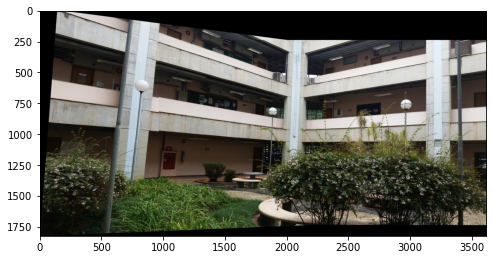

In [7]:
H, _ = compute_homograpy(imgs[0], imgs[1], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[1], imgs[0], H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_left, cv2.COLOR_BGR2RGB))

#### (1 -> 2) -> 3

Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.


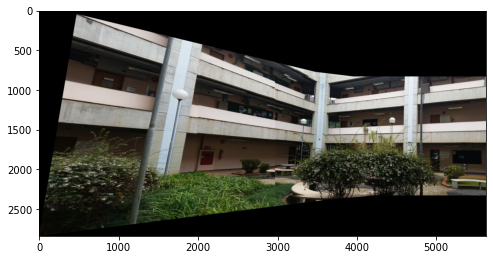

In [8]:
H, _ = compute_homograpy(img_res_left, imgs[2], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[2], img_res_left, H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_left, cv2.COLOR_BGR2RGB))

#### 6 -> 5

Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.


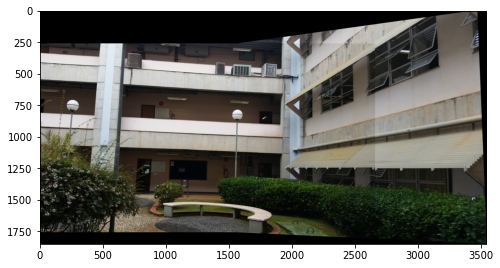

In [9]:
H, _ = compute_homograpy(imgs[5], imgs[4], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[4], imgs[5], H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_right, cv2.COLOR_BGR2RGB))

#### (6 -> 5) -> 4

Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.


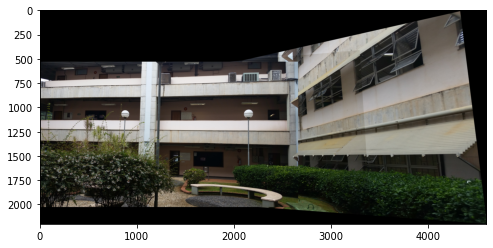

In [10]:
H, _ = compute_homograpy(img_res_right, imgs[3], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[3], img_res_right, H)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_res_right, cv2.COLOR_BGR2RGB))

#### Final image

Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.


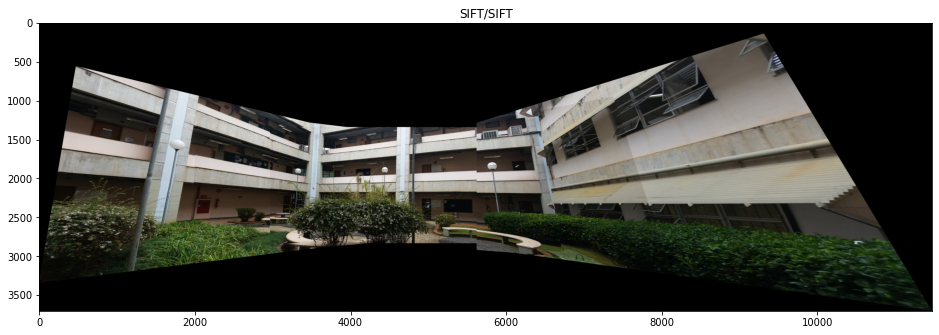

In [11]:
# H, _ = compute_homograpy(img_res_left, img_res_right, DETECTOR, DESCRIPTOR)
# img_res = warpPerspective(img_res_right, img_res_left, H)

H, _ = compute_homograpy(img_res_right, img_res_left, DETECTOR, DESCRIPTOR)
img_res_sift = warpPerspective(img_res_left, img_res_right, H)

fig = plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(img_res_sift, cv2.COLOR_BGR2RGB))
plt.title("SIFT/SIFT")
plt.show()

## Mosaic with FAST/BRIEF

Same procedure as before, but now using FAST as keypoint detector and BRIEF keypoint descriptor.

Detecting fast keypoints ...
Detected fast keypoints.
Detecting fast keypoints...
Detected fast keypoints.
Detecting fast keypoints ...
Detected fast keypoints.
Detecting fast keypoints...
Detected fast keypoints.
Detecting fast keypoints ...
Detected fast keypoints.
Detecting fast keypoints...
Detected fast keypoints.
Detecting fast keypoints ...
Detected fast keypoints.
Detecting fast keypoints...
Detected fast keypoints.
Detecting fast keypoints ...
Detected fast keypoints.
Detecting fast keypoints...
Detected fast keypoints.


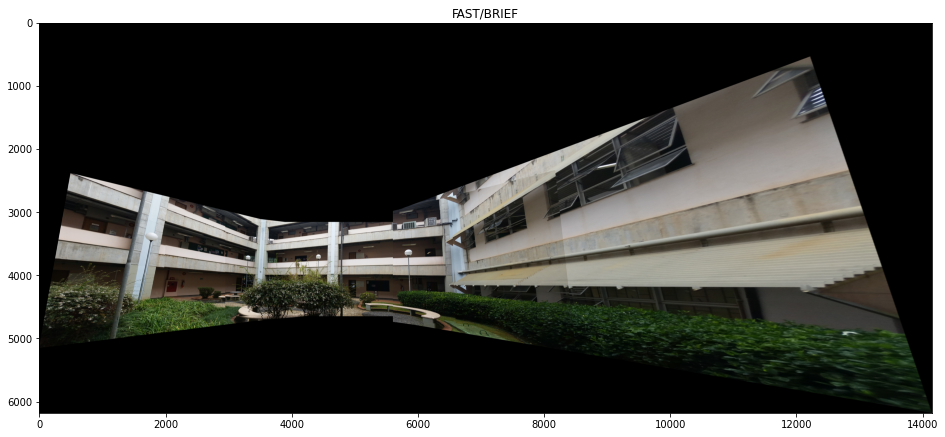

In [12]:
DETECTOR, DESCRIPTOR = 'fast', 'brief'

H, _ = compute_homograpy(imgs[0], imgs[1], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[1], imgs[0], H)

H, _ = compute_homograpy(img_res_left, imgs[2], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[2], img_res_left, H)

H, _ = compute_homograpy(imgs[5], imgs[4], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[4], imgs[5], H)

H, _ = compute_homograpy(img_res_right, imgs[3], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[3], img_res_right, H)

H, _ = compute_homograpy(img_res_right, img_res_left, DETECTOR, DESCRIPTOR)
img_res_fast = warpPerspective(img_res_left, img_res_right, H)

fig = plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(img_res_fast, cv2.COLOR_BGR2RGB))
plt.title("FAST/BRIEF")
plt.show()

## Mosaic with ORB/ORB

Same procedure as before, but now using ORB as keypoint detector and descriptor.

Detecting orb keypoints ...
Detected orb keypoints.
Detecting orb keypoints...
Detected orb keypoints.
Detecting orb keypoints ...
Detected orb keypoints.
Detecting orb keypoints...
Detected orb keypoints.
Detecting orb keypoints ...
Detected orb keypoints.
Detecting orb keypoints...
Detected orb keypoints.
Detecting orb keypoints ...
Detected orb keypoints.
Detecting orb keypoints...
Detected orb keypoints.
Detecting orb keypoints ...
Detected orb keypoints.
Detecting orb keypoints...
Detected orb keypoints.


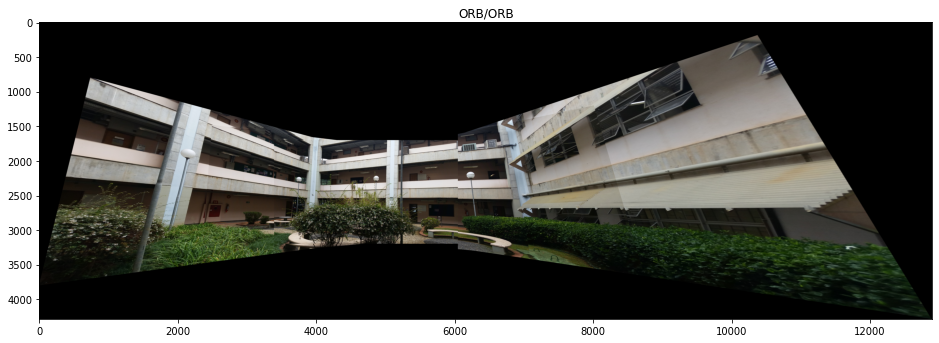

In [13]:
DETECTOR, DESCRIPTOR = 'orb', 'orb'

H, _ = compute_homograpy(imgs[0], imgs[1], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[1], imgs[0], H)

H, _ = compute_homograpy(img_res_left, imgs[2], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[2], img_res_left, H)

H, _ = compute_homograpy(imgs[5], imgs[4], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[4], imgs[5], H)

H, _ = compute_homograpy(img_res_right, imgs[3], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[3], img_res_right, H)

H, _ = compute_homograpy(img_res_right, img_res_left, DETECTOR, DESCRIPTOR)
img_res_orb = warpPerspective(img_res_left, img_res_right, H)

fig = plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(img_res_orb, cv2.COLOR_BGR2RGB))
plt.title("ORB/ORB")
plt.show()

## Comparing with groundtruth

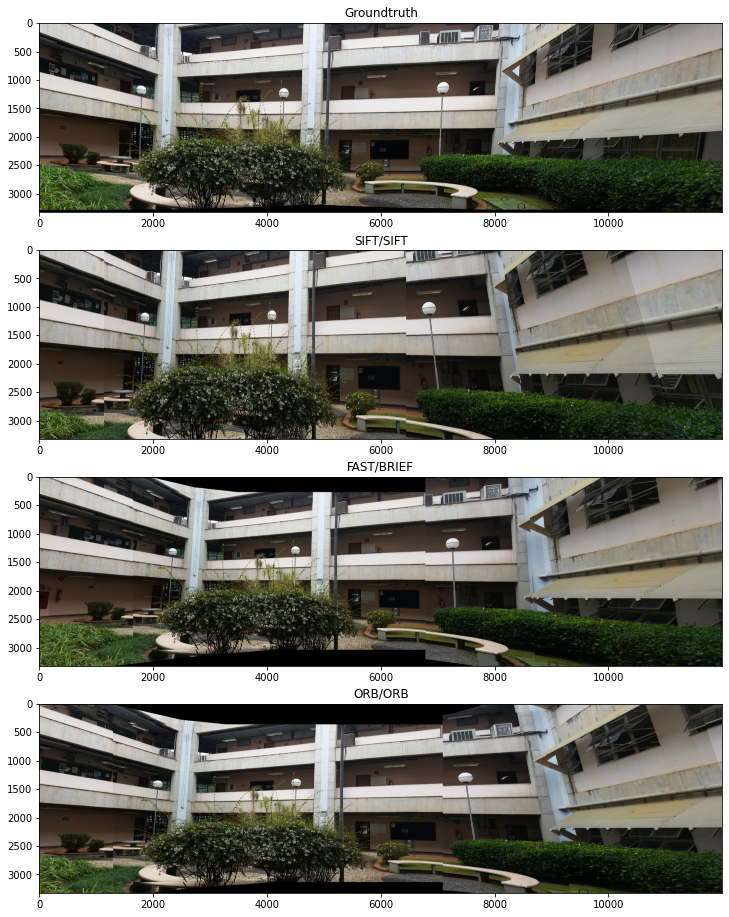

In [14]:
# Define region to enable comparison
x, y, w, h = 3800, 1700, 12000, 4500
crop_groundtruth = img_groundtruth[y:y+h, x:x+w]
x, y, w, h = 2400, 1400, 6000, 1400
crop_sift = img_res_sift[y:y+h, x:x+w]
crop_sift = cv2.resize(crop_sift, (crop_groundtruth.shape[1], crop_groundtruth.shape[0]), interpolation = cv2.INTER_AREA)
x, y, w, h = 2100, 3000, 6200, 1800
crop_fast = img_res_fast[y:y+h, x:x+w]
crop_fast = cv2.resize(crop_fast, (crop_groundtruth.shape[1], crop_groundtruth.shape[0]), interpolation = cv2.INTER_AREA)
x, y, w, h = 2800, 1500, 5500, 1800
crop_orb = img_res_orb[y:y+h, x:x+w]
crop_orb = cv2.resize(crop_orb, (crop_groundtruth.shape[1], crop_groundtruth.shape[0]), interpolation = cv2.INTER_AREA)

fig = plt.figure(figsize=(32, 16))
plt.subplot(4, 1, 1)
plt.imshow(cv2.cvtColor(crop_groundtruth, cv2.COLOR_BGR2RGB))
plt.title("Groundtruth")
plt.subplot(4, 1, 2)
plt.imshow(cv2.cvtColor(crop_sift, cv2.COLOR_BGR2RGB))
plt.title("SIFT/SIFT")
plt.subplot(4, 1, 3)
plt.imshow(cv2.cvtColor(crop_fast, cv2.COLOR_BGR2RGB))
plt.title("FAST/BRIEF")
plt.subplot(4, 1, 4)
plt.imshow(cv2.cvtColor(crop_orb, cv2.COLOR_BGR2RGB))
plt.title("ORB/ORB")
plt.show()

### Show image difference

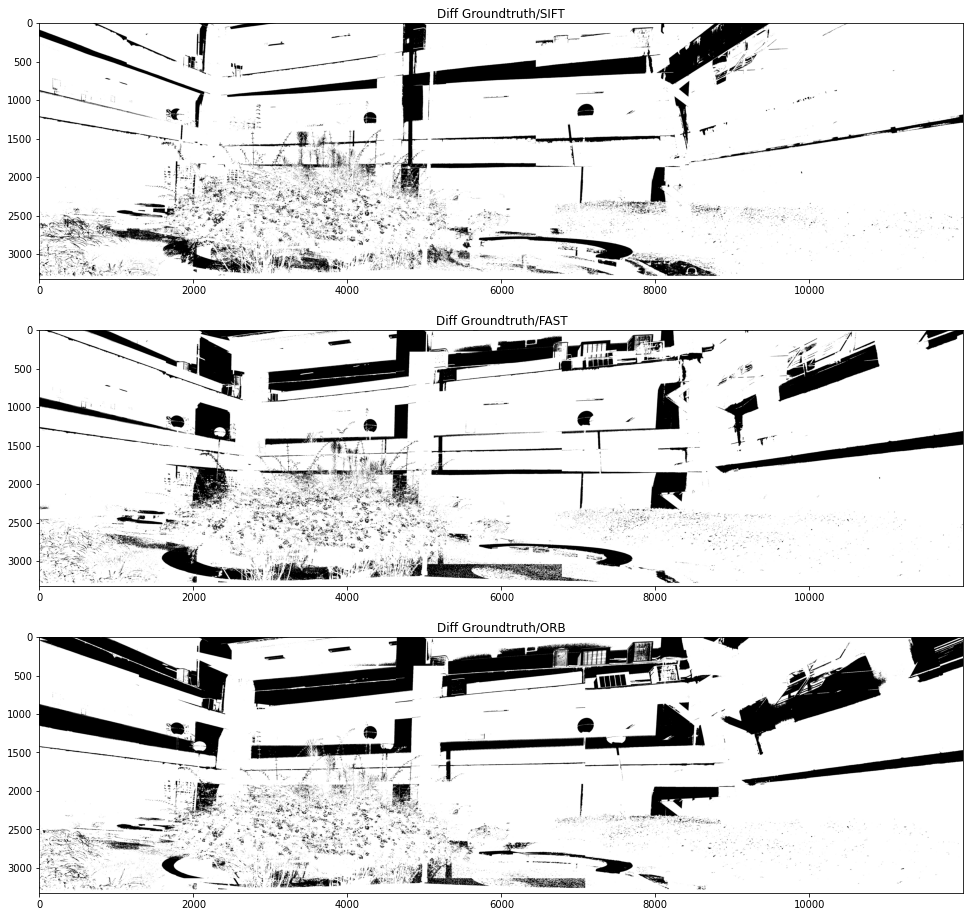

In [15]:
fig = plt.figure(figsize=(32, 16))
plt.subplot(3, 1, 1)
diff_sift = cv2.subtract(crop_groundtruth, crop_sift)
diff_sift = cv2.cvtColor(diff_sift, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(diff_sift, 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("Diff Groundtruth/SIFT")
plt.subplot(3, 1, 2)
diff_fast = cv2.subtract(crop_groundtruth, crop_fast)
diff_fast = cv2.cvtColor(diff_fast, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(diff_fast, 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("Diff Groundtruth/FAST")
plt.subplot(3, 1, 3)
diff_orb = cv2.subtract(crop_groundtruth, crop_orb)
diff_orb = cv2.cvtColor(diff_orb, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(diff_orb, 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("Diff Groundtruth/ORB")
plt.show()

### Show RMSE between the groundtruth mosaic and the generated ones

In [16]:
print("RMSE SIFT/SIFT", np.sqrt(np.mean((crop_sift-crop_groundtruth)**2)))
print("RMSE FAST/BRIEF", np.sqrt(np.mean((crop_fast-crop_groundtruth)**2)))
print("RMSE ORB/ORB", np.sqrt(np.mean((crop_orb-crop_groundtruth)**2)))

RMSE SIFT/SIFT 9.66742548024671
RMSE FAST/BRIEF 9.758753034247185
RMSE ORB/ORB 9.897781481266959


## Average Blending

A version of warpPerspective with average blending was implemented. However, it did not function as expected, and generated soime "ghosting" artifacts in the final image, as shown below.

Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.
Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.
Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.
Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.
Detecting sift keypoints ...
Detected sift keypoints.
Detecting sift keypoints...
Detected sift keypoints.


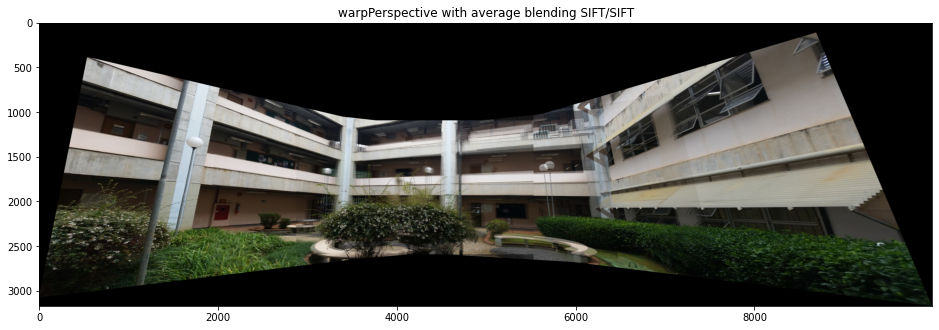

In [17]:
DETECTOR, DESCRIPTOR = 'sift', 'sift'

H, _ = compute_homograpy(imgs[0], imgs[1], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[1], imgs[0], H, blend_average=True)

H, _ = compute_homograpy(img_res_left, imgs[2], DETECTOR, DESCRIPTOR)
img_res_left = warpPerspective(imgs[2], img_res_left, H, blend_average=True)

H, _ = compute_homograpy(imgs[5], imgs[4], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[4], imgs[5], H, blend_average=True)

H, _ = compute_homograpy(img_res_right, imgs[3], DETECTOR, DESCRIPTOR)
img_res_right = warpPerspective(imgs[3], img_res_right, H, blend_average=True)

H, _ = compute_homograpy(img_res_right, img_res_left, DETECTOR, DESCRIPTOR)
img_res_avg_blend = warpPerspective(img_res_left, img_res_right, H, blend_average=True)

fig = plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(img_res_avg_blend, cv2.COLOR_BGR2RGB))
plt.title("warpPerspective with average blending SIFT/SIFT")
plt.show()

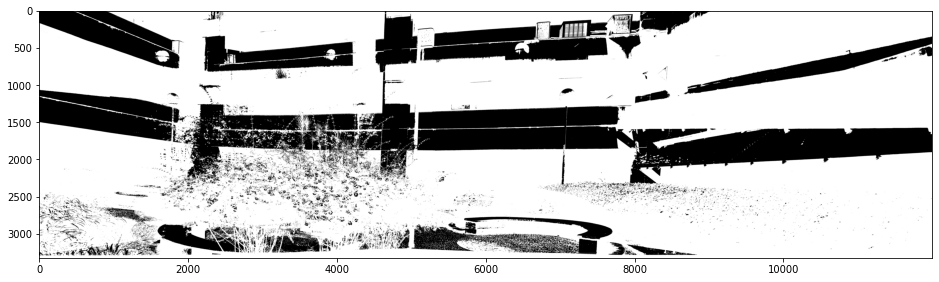

In [18]:
x, y, w, h = 2400, 1400, 6000, 1400
crop_avg_blend = img_res_avg_blend[y:y+h, x:x+w]
crop_avg_blend = cv2.resize(crop_avg_blend, (crop_groundtruth.shape[1], crop_groundtruth.shape[0]), interpolation = cv2.INTER_AREA)

fig = plt.figure(figsize=(16, 16))
diff_avg_blend = cv2.subtract(crop_groundtruth, crop_avg_blend)
diff_avg_blend = cv2.cvtColor(diff_avg_blend, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(diff_avg_blend, 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

In [19]:
print("RMSE Average Blending SIFT/SIFT", np.sqrt(np.mean((crop_avg_blend-crop_groundtruth)**2)))

RMSE Average Blending SIFT/SIFT 9.880956551824408


# Analysis

As we can see, the mosaics generated were very different from the groundtruth. This may be, in part, due to a different approach to transform the images, as there are many ways to combine the given images to create the mosaic. This is confirmed by the RMSE between the mosaics and the difference image.\
When we compare the mosaics generated with the different settings of keypoint detector/descriptor, we can see that they looked very similar, apart from different levels of distortion. This distortion may be justified by the imprecision of the keypoint detection. 